<a id="top"></a>
# Surveying dust structure via GALEX MIS
***

The objective of this tutorial is to create a UV mosaic of a high-latitute cloud, using data from GALEX. We'll query the MAST Archive for Observations, then use the data to create a composite image.

## Learning goals

By the end of this tutorial you will be able to:

- Understand UV images and how they are useful to study dust
- Create masks for circular images
- Create a mosaic from several images using WCS


## Introduction

**GALEX background**: The [Galaxy Evolution Explorer (GALEX)](https://archive.stsci.edu/missions-and-data/galex) was a satellite designed to investigate star formation. It observed the sky in two different bands: in the Near UV (NUV) ($1750-27504$ Å) and in the Far UV (FUV) ($1350-1750$ Å). The GALEX database contains over 600 million source measurements in the ultraviolet domain, with some sources having more than one measurement, making them useful for studying their variable sources. 

**GALEX Medium Imaging survey (MIS) background**: Single orbit exposures (1,500s) of 1000 square degrees in positions that match the Sloan Digital Sky Survey (SDSS). These images present a higher resolution in comparison with AIS, since their exposure time was longer.

Clouds can be visible in UV when they are found close to hot stars. The objective of this tutorial is to extract and display an intensity map image of a high-latitude cloud retrieved from GALEX MIS. High-latitude clouds (Galactic latitude: $|b| > 20-30º$) are interesting because they are considered ideal candidates to study triggered star formation.

## Table of Contents
* [Imports](#Imports)
* [MBM 15 Search in GALEX MIS](#MBM-15-Search-in-GALEX-MIS)
* [Product Selection and Download](#Product-Selection-and-Download)
* [Plotting a Test Image](#Plotting-a-Test-Image)
* [Data Downsizing](#Data-Downsizing)
* [Creating a Circular Mask](#Creating-a-Circular-Mask)
* [Assembling the Mosaic](#Assembling-the-Mosaic)
* [Plotting the Mosaic](#Plotting-the-Mosaic)


## Imports

- `astropy` to use tools needed for performing astronomy and astrophysics with Python, including handling fits files, defining coordinates or choosing the right limits for image visualization.
- `Observations` from _astroquery.mast_ to query the Barbara A. Mikulski Archive for Space Telescopes (MAST).
- `matplotlib` to visualize images.
- `numpy` to manipulate arrays.
- 

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astroquery.mast import Observations
from astropy.visualization import ZScaleInterval
from astropy.wcs import WCS
from photutils.aperture import CircularAperture
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs

## MBM 15 Search in GALEX MIS

We'll access GALEX MIS products using `astroquery.mast`. Let's search for any Observations within a degree of our target, the molecular cloud MBM 15. We should also specify mission with the filter `obs_collection = GALEX`.

Note that we add two additional filters to our query below. First, we use `project="MIS"` to specify the medium imaging survey. There are a few [imaging surveys](http://galex.stsci.edu/doc/CTM/wiki/Public_documentation/Chapter_2.html#GALEX_Science_Surveys) we could choose from, but MIS will give us good coverage of the cloud with a longer exposure time than the all-sky survey. [GALEX has two detectors](http://galex.stsci.edu/doc/CTM/wiki/Public_documentation/Chapter_1.html#Detectors), so let's also choose the Near UV with `filters="NUV"`. Since we're just looking to create a mosaic, it doesn't matter too much which filter we pick; you might have a valid scientific reason to prefer one over the other.

In [2]:
obs = Observations.query_criteria(objectname="MBM 15", radius="1 deg", obs_collection="GALEX", project="MIS", filters="NUV")
len(obs)

9

## Product Selection and Download

With nine Observations, we should be able to a mosaic with a good view of the nebula. Now we need to get the data products: the actual files associated with these Observations.

In [3]:
prod = Observations.get_product_list(obs)
len(prod)

2089

Woah! Over 2000 files from just 9 Observations. Many of these files were intended for calibration or data validation, so we'll just select files that are marked as `"SCIENCE"` type. We'll also keep only files that have been flagged as a "minimum recommended products". These files are considered the absolute minimum needed to do analyze the Observations, which will work well for our mosaic.

In [4]:
# The manifest will save the download status (i.e. success vs. failed) as well as the file location
manifest = Observations.download_products(prod, productType="SCIENCE", mrp_only = True)

INFO: Found cached file ./mastDownload/GALEX/2422974120422539264/MISDR1_18916_0459-fd-int.fits.gz with expected size 11609897. [astroquery.query]
INFO: Found cached file ./mastDownload/GALEX/2920305219898179584/MISWZS03_18917_0284-fd-int.fits.gz with expected size 4409502. [astroquery.query]
INFO: Found cached file ./mastDownload/GALEX/2920762616735334400/MISWZS03_27307_0183-fd-int.fits.gz with expected size 9600414. [astroquery.query]
INFO: Found cached file ./mastDownload/GALEX/2923049600921108480/MISWZS03_28512_0284-fd-int.fits.gz with expected size 9895927. [astroquery.query]
INFO: Found cached file ./mastDownload/GALEX/2923084785293197312/MISWZS03_28513_0284-fd-int.fits.gz with expected size 11000571. [astroquery.query]
INFO: Found cached file ./mastDownload/GALEX/2924140316455862272/MISWZS03_27260_0183o-fd-int.fits.gz with expected size 10251952. [astroquery.query]
INFO: Found cached file ./mastDownload/GALEX/2924175500827951104/MISWZS03_28514_0459o-fd-int.fits.gz with expected s

Great! Now, you might notice that the files end with either `fd-int.fits.gz` or `nd-int.fits.gz`; due to the way GALEX Observations are handled, we're actually getting both the fd (far UV) and nd (near UV) data. We'll handle this gracefully a few cells from now.

In the meantime, let's open the files into a list of fits objects:

In [5]:
hdus = [fits.open(filename) for filename in manifest["Local Path"]]

Since that cell doesn't have any output, we should run a test to make sure everything is working.

## Plotting a Test Image

Let's run our test by getting the data from the first file in the list and plotting it. We won't worry (yet) about plotting the correct coordinates, although we will need to appropriately scale the data based on brightness so it's visible in our plot.

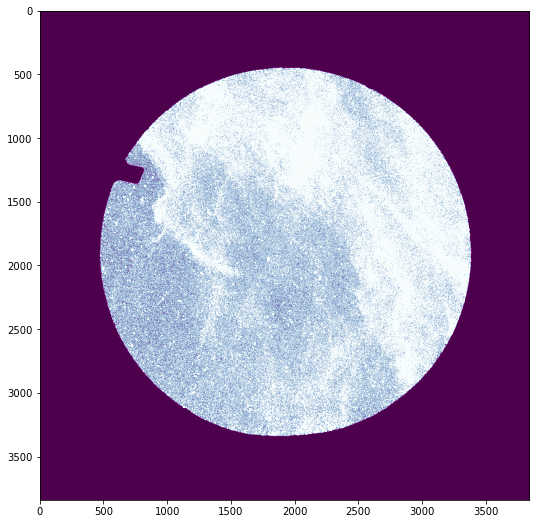

In [6]:
# Create a figure on which to plot our data
fig = plt.figure(0,[9,9])
ax = fig.add_subplot(111)

# Get the primary data from the first fits file
test_data = hdus[0][0].data

# Automatically scale the brightness based on the data
interval = ZScaleInterval(contrast=0.5)
lims = interval.get_limits(test_data)

# Show our data with the scaling from above
ax.imshow(test_data, vmin=lims[0], vmax=lims[1], cmap='BuPu_r')

Excellent. We can aleady see some of the "wispy" or cloud-like structure of our target. 

We should take note of the shape of the data: namely, it is circular. We need to keep this in mind as we construct our mosaic.

## Data Downsizing

These `.fits` files that we've downloaded are actually quite large. To keep Notebook runtime short, we're going to scale down the resolution of the image. The "downgrade factor" is, in effect, making the pixels larger and thus have lower memory/processing requirements. With a default downgrade factor of five, our most complicated cell (coming later) will take about 30 seconds to run. To see the original quality image, you can set `downgrade_factor = 1` (i.e. original quality).

At this step, we also need to find an optimal [WCS](https://docs.astropy.org/en/stable/wcs/index.html) that is big enough to display our combined mosaic. In essence, we know how big each image is and where it was taken on the sky; `find_optimal_celestial_wcs` will do the hard work for us and select an appropriate image size and coordinates.

In [7]:
# determine the angular resolution of the image
res = np.abs(hdus[0][0].header['CDELT1'])

# set up a "downgrade factor" to decrease the resolution of the final combined mosaic, because these files are BIG
downgrade_factor = 5     # = 1 for original quality

# use astropy's find_optimal_celestial_wcs to determine the output WCS 
# for the combined image based on the information in the headers
wcs_out, shape_out = find_optimal_celestial_wcs(hdus, resolution=res*downgrade_factor*u.deg)

## Creating a Circular Mask
Since the GALEX data is circular, we need to create a mask for the data. What we want is a set of valid values within the $0.6^\circ$ observation, surrounded by NaNs. 

Our function below takes `map_in`, keeping only valid values within the circular aperture. All other values are set to NaN; this allows us to compute a meaningful "average" value where the observations overlap.

In [8]:
def galex_mask(map_in, header):
    # define the radius of the circle to be 0.6 degrees: use header information to convert this to pixels
    dr = np.rint(0.6 / header['CDELT2'])
    app = CircularAperture((header['CRPIX1'], header['CRPIX2']), r=dr)
    
    # convert aperture to mask
    amask = app.to_mask(method='center')
    # pad the mask
    amask = np.pad(np.array(amask.data), 480)
    # convert mask to boolean values
    amask = np.array(amask, dtype=bool)
    
    # mask all pixels outside of aperture to "NaN"
    map_in[~amask] = np.nan
    
    return map_in

We'll use this function in our "assembly" below.

## Assembling the Mosaic
It's time to put all of the pieces together! Let's combine these images, following the steps below:

1. Get the data from each HDU.
2. Only keep the NUV data.
3. Set all data outside the aperture to NaN.
4. Reproject the data onto the mosaic WCS to correctly orient all of the images.
5. Take the average of the all the maps to gracefully handle any overlapping regions.

**Note:** this cell will take roughly 30 seconds to run with a downscaling factor of five. If you changed `downgrade_factor` to something lower than five, it will likely take longer. 

In [9]:
# Create an empty "maps" list to hold our outputs
maps = []

# Loop through the hdus, getting the data and header from each
for hdu in hdus:
    fmap = hdu[0].data
    fhead = hdu[0].header
    
    # Only keep the NUV bands. (FUV = 1)
    if fhead['band'] == 2:
        # for each image, use our function to set all pixels outside of the GALEX footprint to NaN
        fmap = galex_mask(fmap, fhead)

        # use reproject to reproject each image to the "combined" output WCS defined earlier
        regmap, foot = reproject_interp((fmap, fhead), wcs_out, shape_out)

        # append the reprojected map to a list
        maps.append(regmap)
        
# average all of the reprojected maps together
combined = np.nanmean(np.dstack((maps)), 2)

/var/folders/04/6pd9ml351599_h45qtqtg_7m0001md/T/ipykernel_82760/1879320563.py:21: RuntimeWarning: Mean of empty slice
  combined = np.nanmean(np.dstack((maps)), 2)


Excellent. Now it's time for the moment of truth.

## Plotting the Mosaic
Just like with our test image, we'll need to create a figure. In this instance, we want to specify the projection to be our mosaic WCS so that the coordinates are labeled. 

Otherwise, we proceed as normal.

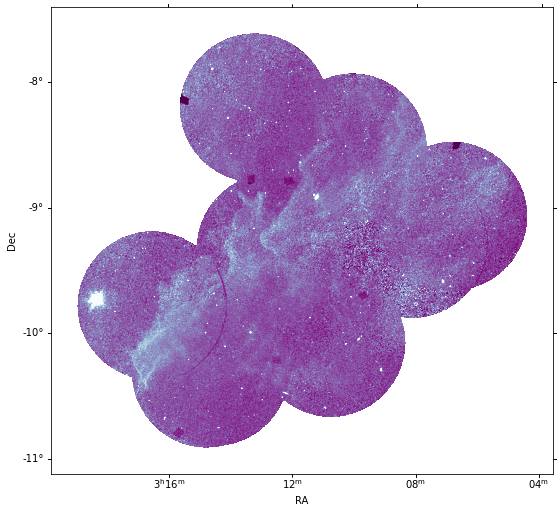

In [10]:
# Create the figure for the new map
fig = plt.figure(0,[9,9])
ax = fig.add_subplot(111, projection=wcs_out)

# Automatically scale the brightness
interval = ZScaleInterval(contrast=0.5)
lims = interval.get_limits(combined)

# Plot the new map
ax.imshow(combined, vmin=lims[0], vmax=lims[1], origin='lower', cmap='BuPu_r')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

# Un-comment the below to save the figure as a jpg
#plt.savefig('mbm15.jpg', dpi=600, bbox_inches='tight')

Beautiful! Our mosaic is complete. You may notice some artifacts where the data was incomplete; you can also see an arc in the lower left corner where our circular NaN aperture didn't quite match the data. How might you improve upon this?


This image corresponds to the 
[Molecular cloud MBM 15](http://simbad.cds.unistra.fr/simbad/sim-id?Ident=mbm+15&submit=submit+id). This molecular cloud belongs to the Orion-Eridanus superbubble, west of the Orion Nebula. More information about this cloud can be found in [Joubaud et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...631A..52J/abstract). 

## Additional Resources

For more information about the MAST archive and details about the tutorial: 

* <a href="https://mast.stsci.edu/api/v0/index.html">MAST API</a> <br>
* <a href="https://archive.stsci.edu/galex/">GALEX via MAST</a> <br>

## About this Notebook

**Authors**: Clara Puerto Sánchez, Claire Murray, Thomas Dutkiewicz <br>
**Keywords**: mosaic, dust, GALEX <br>
**Last Updated**: May 2023 <br>

For support, please contact the Archive HelpDesk at archive@stsci.edu.
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>